# Functional enrichment of biological terms

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by assigning them to biological terms from prior knowledge.

In this notebook we showcase how to use `decoupler` for functional enrichment with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the <a href="https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html">**Usage**</a> tutorial first.

</div>  

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

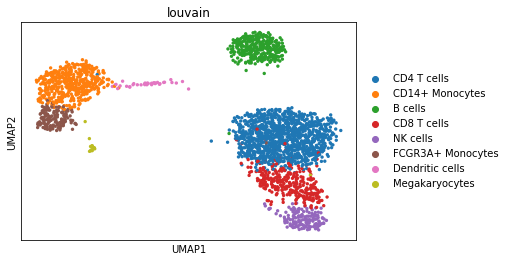

In [3]:
sc.pl.umap(adata, color='louvain')

## MSigDB gene sets

The Molecular Signatures Database ([MSigDB](http://www.gsea-msigdb.org/gsea/msigdb/)) is a resource containing a collection of gene sets annotated to different biological processes.

In [4]:
msigdb = dc.get_resource('MSigDB')
msigdb

label,genesymbol,collection,geneset
0,F2RL1,immunologic_signatures,GSE28237_FOLLICULAR_VS_EARLY_GC_BCELL_DN
1,F2RL1,oncogenic_signatures,MEK_UP.V1_UP
2,F2RL1,tf_targets,ZNF92_TARGET_GENES
3,F2RL1,immunologic_signatures,GSE30083_SP1_VS_SP3_THYMOCYTE_DN
4,F2RL1,immunologic_signatures,GSE15930_NAIVE_VS_48H_IN_VITRO_STIM_IL12_CD8_T...
...,...,...,...
2407284,OR2W5P,immunologic_signatures,GSE22601_DOUBLE_NEGATIVE_VS_CD8_SINGLE_POSITIV...
2407285,OR2W5P,immunologic_signatures,KANNAN_BLOOD_2012_2013_TIV_AGE_65PLS_REVACCINA...
2407286,OR52L2P,immunologic_signatures,GSE22342_CD11C_HIGH_VS_LOW_DECIDUAL_MACROPHAGE...
2407287,CSNK2A3,immunologic_signatures,OCONNOR_PBMC_MENVEO_ACWYVAX_AGE_30_70YO_7DY_AF...


As an example, we will use the hallmark gene sets, but we could have used any other. 

<div class="alert alert-info">

**Note**
    
To see what other collections are available in MSigDB, type: `msigdb['collection'].unique()`.

</div>  

We can filter by for `hallmark`:

In [5]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

label,genesymbol,collection,geneset
89,F2RL1,hallmark,HALLMARK_KRAS_SIGNALING_UP
93,F2RL1,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
536,IL7R,hallmark,HALLMARK_KRAS_SIGNALING_UP
538,IL7R,hallmark,HALLMARK_TNFA_SIGNALING_VIA_NFKB
611,IL7R,hallmark,HALLMARK_INFLAMMATORY_RESPONSE
...,...,...,...
878053,NKX2-2,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878114,PDX1,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878266,PCSK2,hallmark,HALLMARK_PANCREAS_BETA_CELLS
878428,FOXO1,hallmark,HALLMARK_PANCREAS_BETA_CELLS


For this example we will use the resource MSigDB, but we could have used any other such as GO. To see the list of available resources inside `Omnipath`, run `dc.show_resources()`

## Enrichment with Over Representation Analysis

To test if a gene sey is enriched in a given cell, we will run
Over Representation Analysis (`ora`), also known as Fisher exact test, but we could 
do it with any of the other available methods in `decoupler`.

`ora` selects the top 5% expressed genes for each cell, and tests if a gene set is
enriched in the top (or bottom) expressed collection.

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

In [6]:
dc.run_ora(mat=adata, net=msigdb, source='geneset', target='genesymbol', verbose=True)

58 features of mat are empty in 2635 samples, they will be ignored.
Running ora on mat with 2638 samples and 13656 targets for 50 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2638/2638 [00:02<00:00, 1292.43it/s]


The obtained scores (-log10(p-value))(`ora_estimate`) and p-values (`ora_pvals`) are stored in the `.obsm` key:

In [7]:
adata.obsm['ora_estimate']

source,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_COAGULATION,...,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
AAACATACAACCAC-1,1.317500,10.071074,1.658673,0.391150,0.946285,0.653064,3.435109,0.621999,0.460666,0.033139,...,0.451100,2.997417,0.376115,2.997417,11.149969,5.664834,0.179224,1.996328,0.165837,0.181499
AAACATTGAGCTAC-1,1.317500,10.825559,3.326873,-0.000000,2.116838,-0.000000,0.270934,0.340281,0.810018,0.033139,...,2.508805,1.666912,0.678600,3.765025,2.599805,1.606474,0.179224,1.578525,-0.000000,0.181499
AAACATTGATCAGC-1,2.919346,7.257330,2.163150,0.391150,2.116838,0.225447,5.766530,0.340281,0.460666,0.136104,...,1.983812,5.477067,0.041229,2.295738,9.664157,2.060727,0.357451,3.488813,0.165837,0.536606
AAACCGTGCTTCCG-1,2.919346,7.928895,1.658673,1.040001,2.594660,-0.000000,3.435109,0.621999,0.206674,0.595661,...,1.983812,4.593055,0.376115,1.666912,7.584396,2.561403,0.602180,1.204925,0.506356,0.536606
AAACCGTGTATGCG-1,0.513621,10.071074,2.163150,1.040001,1.680902,1.239647,0.672315,-0.000000,0.460666,0.595661,...,1.510836,1.666912,0.041229,1.119758,1.799358,1.202151,0.357451,0.379035,0.165837,0.081326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,3.402233,5.982209,1.211746,1.040001,3.111822,-0.000000,7.097779,0.144395,2.334496,0.595661,...,1.983812,2.295738,0.162598,2.997417,6.933300,0.851656,0.357451,5.295349,0.165837,0.791739
TTTCTACTGAGGCA-1,2.919346,7.257330,6.180487,1.876995,1.680902,0.653064,0.944344,0.144395,0.460666,1.367227,...,5.796310,2.295738,0.376115,2.997417,2.599805,8.749528,0.179224,2.455590,-0.000000,0.081326
TTTCTACTTCCTCG-1,1.008455,7.257330,2.163150,-0.000000,2.116838,0.653064,2.456295,0.035634,0.810018,0.136104,...,1.094316,0.665563,0.041229,1.666912,8.950467,3.105400,0.067346,4.661261,-0.000000,0.332800
TTTGCATGAGAGGC-1,1.008455,5.380289,0.272201,-0.000000,0.653957,0.653064,0.143311,0.144395,0.206674,0.033139,...,0.234800,2.295738,0.041229,0.318480,1.449199,4.971691,0.067346,1.996328,-0.000000,0.081326


## Visualization

To visualize the obtianed scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract them from the `adata` object.

In [8]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 2638 × 50
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'ora_estimate', 'ora_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

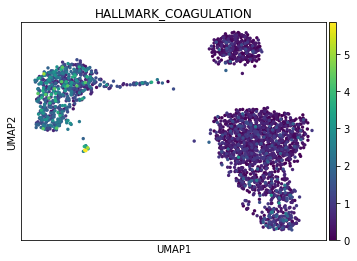

In [9]:
sc.pl.umap(acts, color='HALLMARK_COAGULATION')

The cells highlighted seem to be enriched by coagulation.

## Exploration

With `decoupler` we can also see what is the mean enrichment per group:

In [10]:
mean_enr = dc.summarize_acts(acts, groupby='louvain', min_std=1)
mean_enr

,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_APOPTOSIS,HALLMARK_COAGULATION,HALLMARK_COMPLEMENT,HALLMARK_HYPOXIA,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_MTORC1_SIGNALING,HALLMARK_MYC_TARGETS_V1,HALLMARK_OXIDATIVE_PHOSPHORYLATION,HALLMARK_P53_PATHWAY,HALLMARK_TNFA_SIGNALING_VIA_NFKB
B cells,8.079591,1.749463,0.286118,1.054397,3.981507,5.315256,7.487265,2.784845,19.096043,6.167998,3.122765,3.910282
CD14+ Monocytes,6.893857,4.157110,1.551010,5.085937,5.504116,6.724769,9.910409,3.744251,15.245032,8.739642,4.488810,6.554947
CD4 T cells,6.738094,2.542511,0.385318,1.387077,5.477199,5.183809,6.133497,3.825152,21.438015,7.835927,4.455711,5.101736
CD8 T cells,9.274370,2.505335,0.521227,2.662215,5.422219,5.628405,7.875100,4.289899,20.455368,7.498560,4.230061,5.271203
Dendritic cells,9.610945,4.332600,1.328719,3.415317,6.171379,8.055038,11.730546,5.031778,24.268009,13.322536,5.185035,6.472893
FCGR3A+ Monocytes,8.127956,4.315158,1.711685,6.117206,5.982983,9.113420,12.319559,5.003101,17.339090,9.935337,4.955063,5.566297
Megakaryocytes,3.524540,2.138839,3.315179,2.527668,1.780706,1.790546,1.843046,2.255984,4.896301,2.319902,1.679166,1.696074
NK cells,9.808369,2.257473,0.700178,3.285920,5.401470,7.382476,9.604524,4.653162,18.678684,7.388927,4.184835,4.102460


We can visualize which group is more enriched using `seaborn`:

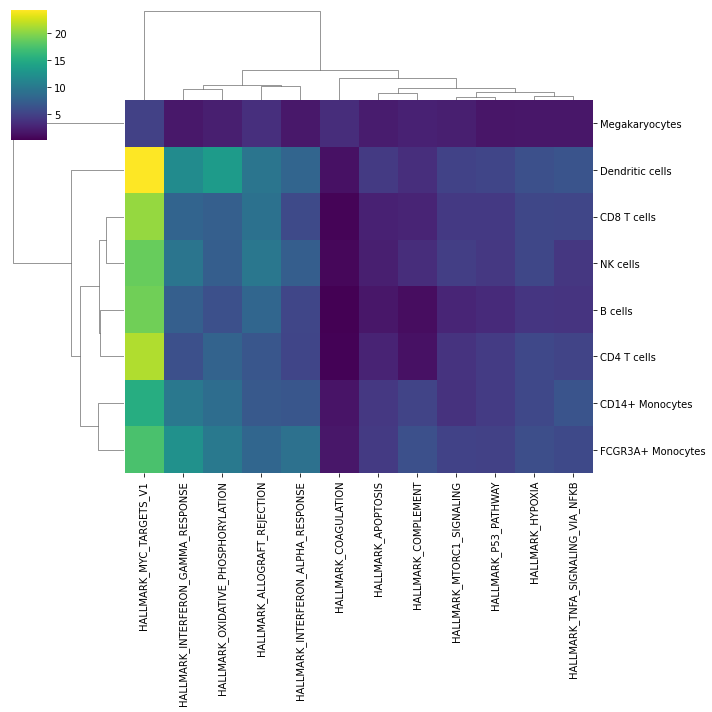

In [11]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In this specific example, we can observe that most cell types are enriched by targets of MYC, a global regulator of the immune system, and megakaryocytes are enriched by coagulation genes.